<h3>Temporal estimation of spring snow depletion in the Adventdalen valley, Svalbard with Sentinel-2</h3>


![](Images/dji_intro_img.JPG)

**Import Python packages**

In [1]:
# Import packages

import ee
import pandas as pd
import geopandas as gpd
import numpy as np
import numpy.ma as ma
import json
import matplotlib.pyplot as plt
import warnings
import os
import re
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
import sys
import xarray as xr
import rioxarray

**Access the Earth Engine**

In [2]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AfJohXlAzRl8ddw3IKG_9vOzcNXRZW_SVkGLcmFMypJJRjS8xBgpPLzLnk4



Successfully saved authorization token.


**Built the Sentinel-2 TOA image collection for the area of interest (AOI)**

In [3]:
# functions used in the building process of the image collection: 


# clip each image of the collection to the exent of the study area

def clipextent(img):
    
    return img.clip(aoi_fc)

# add day-of-the-year (DOY) band for time series analysis, each pixel represents the DOY of the acquisition

def add_doy(image):

    date = ee.Date(image.get('system:time_start'))

    doy = date.getRelative('day', 'year')

    return image.addBands(ee.Image.constant(doy).rename('DOY')).toFloat()

# compute Normalised Differenced Snow Index (NDSI)

def ndsi(img):

    ndsi = img.normalizedDifference(['B3', 'B11'])

    return img.addBands(ndsi.rename('NDSI'))

# compute Normalised Differenced Water Index(NDWI)

def ndwi(img):

    ndwi = img.normalizedDifference(['B3', 'B8'])

    return img.addBands(ndwi.rename('NDWI'))

# reproject each image to pixel resolution of 40 m and set crs

def reproj(image):
    return image.reproject(ee.Projection('EPSG:32633'), scale=20)

# coregistrate images in the collection

def coreg(image):

    image = image.clip(aoi_fc)

    image = image.reproject(crs=reference_projection.crs(), scale=20)

    image = image.resample('bilinear')

    return image

In [4]:
# read vector file of the study area

os.chdir('/Users/janikhoffmann/Desktop/projects/tundra_sensecence_svalbard/snowmelt/SentinelSnowmelt')
vecpath = "Vectordata/aoi.geojson"

adventd_plots = gpd.read_file(vecpath)

with open(vecpath) as f:
    geojson = json.load(f) # load geojson aoi

aoi_fc = ee.FeatureCollection(geojson) # convert geojson to feature collection


# build the EE image collection

observation_year = 2019 # define observation year

start_time = ee.Date.fromYMD(observation_year, 3, 30) # define start and 
end_time = ee.Date.fromYMD(observation_year, 8, 1) # end time

# define collection parameters (AOI, cloud cover threshold), apply the beforehand defined functions and sort by acquisition date

s2toa = ee.ImageCollection('COPERNICUS/S2').filterBounds(aoi_fc).filterDate(start_time, end_time).filter(ee.Filter.lt('CLOUD_COVERAGE_ASSESSMENT', 20)).map(
    clipextent).sort('system:time_start').map(add_doy).map(ndsi).map(ndwi).map(reproj).map(add_doy)

# select NDSI and DOY bands

s2toaNDSI = s2toa.select(['DOY','NDSI', 'NDWI'])

# coregistrate images to ensure consistent pixel overlap

reference_image = s2toaNDSI.first()
reference_projection = reference_image.projection()

s2toaNDSI = s2toaNDSI.map(coreg)

# print image collection parameters

print("Image Collection overview:")
print("Image Collection size:", s2toaNDSI.size().getInfo())
print("Available bands:", s2toaNDSI.first().bandNames().getInfo())
print("Image CRS:", s2toaNDSI.first().projection().getInfo()['crs'])
print("Image pixel-spacing:", s2toaNDSI.first().projection().nominalScale().getInfo())

Image Collection overview:
Image Collection size: 58
Available bands: ['DOY', 'NDSI', 'NDWI']
Image CRS: EPSG:32633
Image pixel-spacing: 20


**Export the images in the collection as GeoTIFF raster files to Drive**

In [10]:
# define an export task function

def export_image(image, image_name, folder_name):
    
    # define the export parameters
    export_params = {
        'image': image.select("NDSI", "NDWI", "DOY"),
        'description': image_name,
        'folder': folder_name,
        'scale': 20,
        'region': aoi_fc.geometry(),
        'fileFormat': 'GeoTIFF'
    }

    # execute the export tast
    task = ee.batch.Export.image.toDrive(**export_params)
    task.start()

# convert the image collection to an image list

image_list = s2toaNDSI.toList(s2toaNDSI.size())

# export the images to Drive

folder_name = "NDSI_snowmelt_doy" # set Drive folder name

for i in range(image_list.size().getInfo()):
    image = ee.Image(image_list.get(i))
    band1 = image.select('NDSI').toFloat()
    band2 = image.select('NDWI').toFloat()
    band3 = image.select('DOY').toFloat()
    image_float = ee.Image.cat([band1, band2, band3])
    image_name = 'image_2019_' + str(i)  # set file naming convention
    export_image(image_float, image_name, folder_name)

**Read the raster data with the rasterio package and mask the Fjord area**

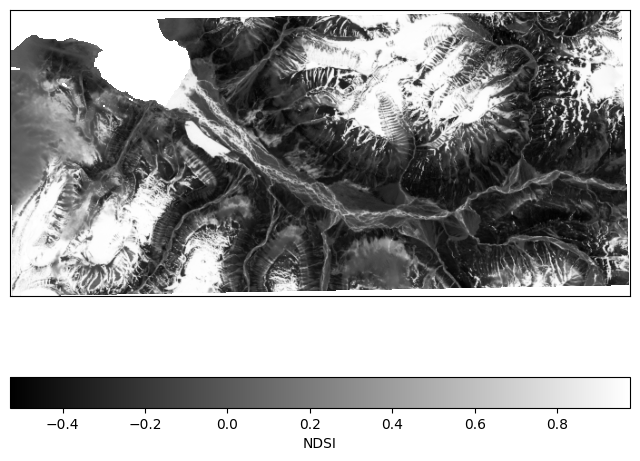

In [8]:
os.chdir('/Users/janikhoffmann/Desktop/projects/tundra_sensecence_svalbard/snowmelt/SentinelSnowmelt/Rasterdata/2021')
folder_path = os.getcwd()

raster_list = []

# read each file in the working directory as spatial raster

for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        file_path = os.path.join(folder_path, filename)
        src = rasterio.open(file_path)
        raster_list.append(src)

# create a mask for the Fjord area in the North-West of the image based on the NDWI of a template image

maskedraster_list = []
template = raster_list[7]
ndwi_band = template.read(2)

for i in raster_list:

    raster_data = i.read()
    
    mask = np.where(ndwi_band > 0.4, True, False) # remove pixels where NDWI is > 0.4
    
    masked_raster = np.ma.array(raster_data, mask=np.broadcast_to(mask, raster_data.shape)) # apply mask to every raster
    
    maskedraster_list.append(masked_raster)

# visualize a template image

plt.figure(figsize=(8, 7))
plt.imshow(maskedraster_list[10][0], cmap ="gray")
plt.xticks([])
plt.yticks([])
colorbar = plt.colorbar(orientation='horizontal')
colorbar.set_label("NDSI")
plt.show()

**Convert raster stack to time series dataframe**

In [9]:
# create a template dataframe with one image and store pixel coordinates

img = raster_list[1] # select an example image
rows, cols = img.shape # extract the image number of rows and columns
ndsi_band = img.read(1) # read NDSI band
doy_band = img.read(3) # read DOY band (to naming the columns after the acquisition DOY)

pix_values = []
pix_coordinates = []

# extract the NDSI values and coordinates for each pixel

for row in range(rows):
    for col in range(cols):
        val_ndsi = ndsi_band[row, col]
        coordinates = img.xy(row, col)

        pix_values.append([val_ndsi])
        pix_coordinates.append(coordinates)

# create a dataframe

mean_doy = np.mean(doy_band)
df = pd.DataFrame(pix_values, columns = [f'NDSI_{doy_band[150, 150]}'])
df["coordinates"] = pix_coordinates


# repetitively add new column and insert NDSI data points in for rows based on the template dataframe

for raster in raster_list:
    ndsi_band = raster.read(1)
    doy_band = raster.read(3)

    df[f'NDSI_{doy_band[150, 150]}'] = ndsi_band.ravel()

# edit dataframe

df = df.fillna(0) # replace NaN values with 0
df = df.reset_index(drop=True)
sorted_cols = sorted(df.columns, key=lambda x: float(x.split('_')[1]) if len(x.split('_')) > 1 else 0) # sort columns based on the acquisition DOY
df = df[sorted_cols]
df_drop = df.drop(df.columns[0], axis=1)

# show example pixel-scaled time series from dataframe

df_drop.iloc[10110:10114]

,NDSI_95.0,NDSI_110.0,NDSI_122.0,NDSI_128.0,NDSI_135.0,NDSI_136.0,NDSI_138.0,NDSI_142.0,NDSI_156.0,NDSI_176.0,NDSI_185.0,NDSI_186.0
10110,0.756061,0.704565,0.799373,0.741212,0.763693,0.833125,0.832782,0.764743,0.832052,0.102391,-0.420425,-0.448086
10111,0.760295,0.712975,0.791564,0.738802,0.757541,0.825803,0.823897,0.757771,0.803563,-0.200101,-0.439819,-0.465395
10112,0.680322,0.663135,0.682218,0.665428,0.675112,0.706858,0.686564,0.613646,0.248171,-0.338191,-0.365969,-0.380369
10113,0.588765,0.658892,0.689992,0.697771,0.716769,0.759349,0.749970,0.677419,0.144666,-0.345058,-0.359343,-0.366889


**Detect snowmelt DOY based on NDSI threshold**

In [ ]:
# loop through dataframe to detect the point when the threshold is crossed

results = pd.DataFrame(columns=['DOY_THRESHPASS'])

processed_rows = 0

# iterate through each row
for index, row in df_drop.iterrows():
    doy_threshpass = None
    for i, value in enumerate(row):
        if value < 0.4:
            doy_threshpass = i
            break  # stop searching once the first value below 0.4 is found

    results.loc[index] = [doy_threshpass]

    # print progress of loop

    processed_rows += 1
    percentage = (processed_rows / len(df_drop)) * 100

    progress_text = f"Progress: {percentage:.2f}%"

    sys.stdout.write(f"\r{progress_text}")
    sys.stdout.flush()

print("\nProcessing finished")

Progress: 25.06%

In [ ]:
# extract the DOY string from the columns and store them in a list of numbers

number_pattern = r'(\d+\.\d+)' # number pattern to detect
column_names = df_drop.columns
numbers_list = []

for column_name in column_names: # detect number pattern in column names
    matches = re.findall(number_pattern, column_name)
    if matches:

        number = int(float(matches[0]))
        numbers_list.append(number) # if found, add to the number list

numbers_list = [int(number) for number in numbers_list] # convert to integer

results = results.fillna(0) # convert no data values to zero
results = results.astype(int) # convert to integer
results['doy_before'] = results['DOY_THRESHPASS'] - 1 # add column with the DOY of the acquisition before snowmelt was detected

# convert each cell index value to the corresponding DOY value based on the numbers list

def index_to_number(index):
    if index >= 1 and index <= len(numbers_list):
        return numbers_list[index - 1]
    else:
        return None

df_SMdoy_s2 = results.applymap(index_to_number)
df_SMdoy_s2['doy_median'] = df_SMdoy_s2[['DOY_THRESHPASS', 'doy_before']].median(axis=1) # calculate median DOY as estimation for snowmelt time

**Convert dataframe with DOY values to raster format**

In [ ]:
# re-transform the dataframe to xarray format

df_SMdoy_s2 = df_SMdoy_s2[['doy_median']].copy() # select the column that stores median DOY

df_SMdoy_s2['coordinates'] = df['coordinates'] # get pixel coordinates
df_SMdoy_s2 = df_SMdoy_s2.fillna(0)
df_SMdoy_s2['x'] = df_SMdoy_s2['coordinates'].apply(lambda coord: coord[0]) # select x coordinate and store in separate column
df_SMdoy_s2['y'] = df_SMdoy_s2['coordinates'].apply(lambda coord: coord[1]) # select y coordinate and store in separate column
df_SMdoy_s2.drop(columns=['coordinates'], inplace=True)

xarr = df_SMdoy_s2.set_index(['x', 'y']).to_xarray() # convert dataframe to xarray
xarr = xarr.transpose('y', 'x')

# write the raster with xarray

new_crs = "EPSG:32633" # define crs
xarr.rio.set_crs(new_crs, inplace=True)
updated_crs = xarr.rio.crs

out_path = '/content/drive/My Drive/uniwue/svalbard/s2_sm_2021.tif' # define output path
xarr.doy_median.rio.to_raster(out_path, crs=new_crs) # write raster

**Visualize snowmelt map**

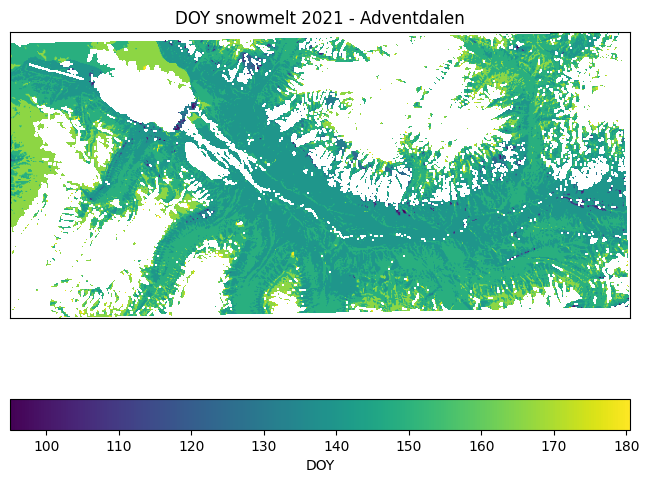

In [21]:
# read snowmelt map

os.chdir('/Users/janikhoffmann/Desktop/projects/tundra_sensecence_svalbard/snowmelt/SentinelSnowmelt')
path = 'Rasterproducts/s2_sm_2021.tif'

with rasterio.open(path) as src:
    raster = src.read(1)
    width= src.width
    height = src.height
    bands = src.count
    meta = src.meta
    resolution = src.res

mask = np.where(raster < 90, True, False)
raster = np.ma.array(raster, mask=mask)

raster = np.flipud(raster)

# visualize snowmelt map

plt.figure(figsize=(8, 7))
plt.imshow(raster, cmap ="viridis")
plt.xticks([])
plt.yticks([])
plt.title("DOY snowmelt 2021 - Adventdalen")
colorbar = plt.colorbar(orientation='horizontal')
colorbar.set_label("DOY")
plt.show()